# Quantile Regression DQN (QR-DQN)

## Introduction

Quantile Regression DQN (QR-DQN) is a distributional reinforcement learning algorithm that represents value distributions using quantile regression. Introduced by Dabney et al. in 2017, it provides a more flexible alternative to C51 by directly learning the quantiles of the return distribution.

## Core Concepts

### Distributional Perspective

Like C51, QR-DQN models the full distribution of returns, but uses a different parameterization:

$$
Z(s,a) = \sum_i \tau_i * \delta_{\theta_i(s,a)}
$$

where:

- $\tau_i$ are the quantile levels (fixed)
- $\theta_i(s,a)$ are the learned quantile values
- $\delta$ is the Dirac delta function

### Quantile Approximation

1. **Fixed Quantile Levels**
   - N equally spaced quantiles: $\tau_i = (i-0.5)/N$
   - No need to specify value bounds
   - Typically N=200 quantiles

2. **Quantile Values**
   - Network outputs $\theta_i(s,a)$ for each quantile level
   - Expected value: $\mathbb{E}[Z(s,a)] = (1/N) * \sum_i \theta_i(s,a)$

### Quantile Huber Loss

The key innovation is the use of quantile regression loss:

$$
L(\theta) = \mathbb{E}[\Sigma_i \Sigma_j \rho_{\tau_i}(r + \gamma \theta_j(s',a') - \theta_i(s,a))]
$$

where $\rho_{\tau}$ is the quantile Huber loss:

$$
\rho_{\tau}(u) = |\tau - \mathbb{1}\{u < 0\}| * L_{\kappa}(u)
$$

and $L_{\kappa}$ is the Huber loss with threshold $\kappa$.

## Training Process

1. **Forward Pass**
   - Input state s to network
   - Output N quantile values for each action

2. **Action Selection**
   - Use mean of quantiles: $(1/N) * \sum_i \theta_i(s,a)$
   - Follow $\epsilon$-greedy policy

3. **Learning**
   - Sample transitions from replay buffer
   - Compute target quantiles
   - Update network using quantile Huber loss

## Advantages

1. **Flexible Distribution Representation**
   - No fixed support required
   - Can adapt to any return range
   - Better handles heavy-tailed distributions

2. **Sample Efficiency**
   - More efficient than C51
   - Better gradient flow
   - Improved learning stability

3. **Risk-Sensitive Control**
   - Direct access to quantiles
   - Easy to implement risk-aware policies
   - Natural uncertainty estimation

## Limitations

1. **Computational Cost**
   - O(N²) complexity in number of quantiles
   - More expensive than C51 for same number of points

2. **Training Stability**
   - Sensitive to learning rate
   - Can be unstable with large N
   - Requires careful hyperparameter tuning

3. **Approximation Quality**
   - Fixed quantile levels may not be optimal
   - May need many quantiles for complex distributions

## Why QR-DQN is Better

1. **Improved Distribution Modeling**
   - More flexible than fixed categorical support
   - Better captures tail behavior
   - Adapts to different value ranges

2. **Statistical Efficiency**
   - Direct optimization of quantiles
   - Better sample complexity
   - More accurate value estimates

3. **Risk-Sensitive Applications**
   - Natural for risk-aware decision making
   - Easy to compute value-at-risk
   - Better suited for safety-critical tasks

## References

1. Dabney, W., Rowland, M., Bellemare, M. G., & Munos, R. (2018). "Distributional reinforcement learning with quantile regression." AAAI Conference on Artificial Intelligence.

2. Dabney, W., Ostrovski, G., Silver, D., & Munos, R. (2018). "Implicit quantile networks for distributional reinforcement learning." International Conference on Machine Learning.

3. Zhou, L., Yang, P., Chen, C., & Gao, X. (2020). "Risk-sensitive reinforcement learning: Near-optimal risk-sample tradeoff in regret." Advances in Neural Information Processing Systems.


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from typing import Dict
import gymnasium as gym
from collections import deque
from typing import Tuple
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer:
    """Experience replay buffer for RL agents."""

    def __init__(self, maxlen: int = 100_000):
        """Initialize replay buffer.

        Args:
            maxlen (int): Maximum size of the buffer
        """
        self.buffer = deque(maxlen=maxlen)

    def append(
        self, experience: Tuple[np.ndarray, np.ndarray, np.ndarray, float, bool]
    ) -> None:
        """Add experience to buffer.

        Args:
            experience (tuple): (state, next_state, action, reward, done)
        """
        self.buffer.append(experience)

    def sample(
        self,
        batch_size: int,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
    ) -> Dict[str, torch.Tensor]:
        """Sample a batch of experiences.

        Args:
            batch_size (int): Size of batch to sample
            device (torch.device): Device to put tensors on

        Returns:
            dict: Dictionary containing batched experiences
        """
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, next_states, actions, rewards, dones = zip(
            *[self.buffer[idx] for idx in indices]
        )

        # Convert to torch tensors
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        # One-hot encode actions
        actions_one_hot = torch.zeros(
            batch_size, actions.max().item() + 1, device=device
        )
        actions_one_hot.scatter_(1, actions.unsqueeze(1), 1)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)

        return {
            "states": states,
            "next_states": next_states,
            "actions": actions_one_hot,
            "rewards": rewards,
            "dones": dones,
        }

    def __len__(self) -> int:
        return len(self.buffer)


In [3]:
QRDQN_CONFIG = {
    "hidden_dim": 128,
    "n_quantiles": 200,  # Number of quantiles
}


class QRDQNNet(nn.Module):
    """Quantile Regression DQN network."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        n_quantiles: int = QRDQN_CONFIG["n_quantiles"],
        hidden_dim: int = QRDQN_CONFIG["hidden_dim"],
    ):
        super().__init__()
        self.action_dim = action_dim
        self.n_quantiles = n_quantiles

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim * n_quantiles),
        )

        # Initialize quantile fractions (τ)
        taus = (
            torch.arange(0, n_quantiles + 1, device="cpu", dtype=torch.float32)
            / n_quantiles
        )
        self.register_buffer("taus", (taus[1:] + taus[:-1]) / 2)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        batch_size = state.shape[0]
        quantiles = self.net(state).view(batch_size, self.action_dim, self.n_quantiles)
        return quantiles

    @torch.no_grad()
    def get_action(self, state: np.ndarray) -> int:
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        quantiles = self.forward(state)
        q_values = quantiles.mean(dim=-1)
        return q_values.argmax().item()

In [4]:
class QRDQNAgent:
    """Quantile Regression DQN Agent."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        learning_rate: float = 0.0003,
        gamma: float = 0.99,
        device: str = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        n_quantiles: int = QRDQN_CONFIG["n_quantiles"],
        hidden_dim: int = QRDQN_CONFIG["hidden_dim"],
    ):
        super().__init__()
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_quantiles = n_quantiles

        # Create networks
        self.online_net = QRDQNNet(state_dim, action_dim, n_quantiles, hidden_dim).to(
            self.device
        )
        self.target_net = QRDQNNet(state_dim, action_dim, n_quantiles, hidden_dim).to(
            self.device
        )
        self.target_net.load_state_dict(self.online_net.state_dict())

        self.optimizer = optim.Adam(self.online_net.parameters(), lr=learning_rate)

    def choose_action(self, state: np.ndarray, epsilon: float = 0.0) -> int:
        if np.random.random() < epsilon:
            return np.random.randint(self.action_dim)
        return self.online_net.get_action(state)

    def _huber_loss(self, td_errors: torch.Tensor, kappa: float = 1.0) -> torch.Tensor:
        """Calculate Huber loss for QR-DQN."""
        return torch.where(
            td_errors.abs() <= kappa,
            0.5 * td_errors.pow(2),
            kappa * (td_errors.abs() - 0.5 * kappa),
        )

    def train(self, batch: Dict[str, torch.Tensor]) -> float:
        states = batch["states"]
        next_states = batch["next_states"]
        actions = batch["actions"]
        rewards = batch["rewards"]
        dones = batch["dones"]

        # Get current quantiles
        current_quantiles = self.online_net(states)
        # Convert one-hot actions to indices
        action_indices = actions.max(1)[1] if actions.dim() > 1 else actions
        current_quantiles = current_quantiles[
            torch.arange(len(states)), action_indices.long()
        ]

        # Get target quantiles
        with torch.no_grad():
            next_quantiles = self.target_net(next_states)
            next_actions = next_quantiles.mean(2).argmax(1)
            next_quantiles = next_quantiles[torch.arange(len(states)), next_actions]

            # Calculate target quantiles
            target_quantiles = (
                rewards.unsqueeze(1)
                + (1 - dones.unsqueeze(1)) * self.gamma * next_quantiles
            )

        # Calculate quantile regression loss
        td_errors = target_quantiles.unsqueeze(1) - current_quantiles.unsqueeze(2)
        huber_loss = self._huber_loss(td_errors)

        # Calculate quantile weights with proper broadcasting
        tau = self.online_net.taus.view(1, -1, 1)  # [1, N, 1]
        below_threshold = (td_errors < 0).float()  # [B, N, N]
        quantile_loss = torch.abs(tau - below_threshold) * huber_loss / self.n_quantiles
        loss = quantile_loss.sum(dim=(1, 2)).mean()

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target(self) -> None:
        self.target_net.load_state_dict(self.online_net.state_dict())


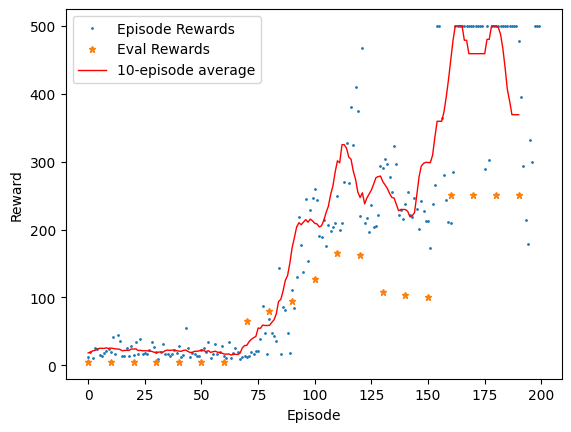

In [5]:
def train_qrdqn(env_name: str, device: str = "cuda") -> None:
    # Create environment
    env = gym.make(env_name)

    # Get state and action dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize agent
    agent = QRDQNAgent(state_dim, action_dim, device=device)

    # Initialize replay buffer
    memory = ReplayBuffer(maxlen=100_000)

    # Training loop
    total_steps = 0
    episode_rewards = []
    eval_rewards = []
    eval_episodes = []

    # Training parameters
    episodes = 200
    eval_freq = 10
    n_eval_episodes = 4
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 5000
    min_memory_size = 1000
    target_update_freq = 100
    batch_size = 128

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Calculate epsilon for exploration
            epsilon = max(
                epsilon_end,
                epsilon_start
                - (epsilon_start - epsilon_end) * total_steps / epsilon_decay,
            )

            # Select action
            action = agent.choose_action(state, epsilon)

            # Take step in environment
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            episode_reward += reward
            total_steps += 1
            # Store experience in replay buffer
            memory.append(
                (
                    state,
                    next_state,
                    int(action),
                    reward,
                    done,
                )
            )

            # Update state
            state = next_state

            loss = 0.0

            # Train agent
            if len(memory) >= min_memory_size:
                batch = memory.sample(batch_size)
                loss = agent.train(batch)

                # Update target network
                if total_steps % target_update_freq == 0:
                    agent.update_target()

            if episode % 10 == 0:
                print(
                    f"Episode {episode:>{len(str(episodes))}}/{episodes} | "
                    f"Reward: {episode_reward:.2f} | "
                    f"Loss: {loss:.4f}",
                    end="\r",
                )

        # Track episode rewards
        episode_rewards.append(episode_reward)

        # Evaluate agent
        if episode % eval_freq == 0:
            eval_reward_list = []
            for _ in range(n_eval_episodes):
                state, _ = env.reset()
                eval_reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        action = agent.choose_action(state, epsilon=0.0)
                    state, reward, done, truncated, _ = env.step(action)
                    eval_reward += reward
                    done = done or truncated
                    eval_reward_list.append(eval_reward)

            mean_eval_reward = np.mean(eval_reward_list)
            eval_rewards.append(mean_eval_reward)
            eval_episodes.append(episode)

    # Close environment
    env.close()

    plt.plot(episode_rewards, "o", ms=1, label="Episode Rewards")
    plt.plot(
        np.arange(len(eval_rewards)) * eval_freq,
        eval_rewards,
        "*",
        ms=5,
        label="Eval Rewards",
    )
    plt.plot(
        np.convolve(episode_rewards, np.ones((10,)) / 10, mode="valid"),
        "r-",
        lw=1,
        label="10-episode average",
    )
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()


train_qrdqn("CartPole-v1")
